# Tanzania Water Pump Classifier

The Tanzanian government has worked in conjunction with for-profit and non-profit organizations to build water pumps across Tanzania to provide its denizens with potable water. These pumps need maintenance to continue to operate. It is expensive, time-consuming, and inefficient to send repair teams, and tools and parts, only when the government receives reports of a faulty pump. The purpose of this project is to create a machine learning algorithm that can predict which pumps need repair or replacement to save the time and money of the Tanzanian government and its cooperative organizations.

This data was from a private Kaggle competition held by BloomTech for its DS36 Data Science cohort; its data mirrors that of the community Kaggle competition.

This documentation presents the project narrative in a CRISP-DM process style.

## Import Libraries

All libraries used throughout the notebook will be initialized here.

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Business Understanding

We want to create a machine learning algorithm that can predict which pumps are non-functional. Let's expand on this goal by further developing our understanding of the stakeholder's needs.

### Goal

The Tanzanian government wants to keep the pumps in working order to provide a reliable source of water for its population.

They have "hired" us to build a model that can turn accessible water pump data into three classes of predictions:

1. Functional (the pump is working)
2. Functional needs repair (the pump needs repair)
3. Non functional (the pump needs replacement)

With the predictions, the Tanzanian government will send the necessary tools and teams to the pumps needing repair, and replacement teams to the broken pumps.

### Additional Factors and Considerations

We should be prepared for the inevitability that our model is unlikely predict with perfect accuracy.

An imperfect classification model is subject to Type I and Type II errors. In the case of water pump classification:

- Type I, False Positive: The model predicts that the pump needs repair or replacement when it is in working condition
- Type II, False Negative: The model predicts that the pump is in working condition when it needs repair or replacement

Both types of errors should be avoided, but a Type II error is much more pressing. The worst case scenario in a Type II error would be when the model predicts a pump to be in working condition when it is broken and needs replacement. We're dealing with water, which is necessary to live. A Type I error would result in a waste of resources (sending repair teams and tools to a working pump), but a Type II error may result in a loss of lives!

We could tune our model to eliminate Type II errors, but this would result in more Type I errors; more pumps that are functional would be marked as needing repair or replacement, which would be an unnecessary drain on repair resources.

If we were able to meet with the stakeholder (the Tanzanian government) we would want to clarify how we should prioritize the reduction of these errors.

We will assume that the stakeholder prefers to begin with a model that is as accurate as possible, and make adjustments to account for these errors when we have an MVP (minimum viable product).

We should also assume that the stakeholder will want some understanding of why the model makes the predictions that it does. We will need to be able to explain which features we choose to include in our model, as well as how those features impact the model.

### Accuracy Metric

For the MVP, we will focus on building a model that is as accurate as possible.

There are several metrics we can use, which have their own benefits and drawbacks:

1. Basic accuracy metric
    - Pros: simple
    - Cons: does not account for precision and recall (measures impact of Type I and Type II errors)
2. Weighted F1 Score
    - Pros: accounts for precision and recall
    - Cons: does not directly account for poor scores in one classification (averages all classification scores)
3. Multiclass ROC AUC
    - Pros: accounts for precision and recall; accounts for poor scores in one classification; easiest to visualize; can average scores for one final metric
    - Cons: introduces subjective assessment of success (multiple measures are weighed, assessor must rank measure importance)

In accordance with the idea that the stakeholder may want to make adjustments to the model to account for errors, multiclass ROC AUC is the best choice. We will implement a 'One vs Rest' style of multiclass ROC AUC, which will give us a total of three graphs, with each graph comparing one feature to the other two. Changes to precision and recall for each class will be most visible while using this metric. In addition, if we wanted a single measure of accuracy, we retain the option to consolidate the scores for each graph into a simple or weighted average.

### Project Plan

Let's outline a plan for how we will approach this project.

1. Data Understanding
    - *Identify data surface qualities*: What is our data format? How many records do we have to train our model?
    - *Verify data quality*: How dirty is the data? Are there any non-existent values? Incorrect values or types?
    - *Understand features*: What kinds of data are available?
    - *Explore data*: What relationships are present in the data? How do we visualize them?
2. Data Preparation
    - *Select / exclude data*: What features and records will we keep or remove? Why?
    - *Clean data*: What values do we need to add, remove, or alter from when we verified data quality?
    - *Format data*: Are the datatypes accurate? Can they be changed? Which are the most useful to our model?
    - *Feature engineering*: Can we introduce better features, or consolidate the features we have to reduce dimensionality?
3. Modeling
    - *Select modeling techniques*: What models will we try?
    - *Determine test design*: How will we test our model?
    - *Build model*: How do we construct our model?
    - *Tune model*: How do we change our model to be more accurate?
    - *Assess model*: What are the results of our tests?
4. Evaluation
    - *Evaluate model result*: Does our model meet the stakeholder's requirements?
    - *Review process*: Did we miss anything? What else should be added?
    - *Determine next steps*: Should we deploy the model, or iterate further?
5. Deployment
    - We expect the stakeholder will want to make this model available for use beyond our project. We will need to create a way for users to provide data to our model, and retrieve its predictions.

The plan is not intended to be strictly sequential - rather, it is intended to be flexible to allow us to return to previous sections to re-evaluate our approach when new information arises or project circumstances change.

## Data Understanding

Before we can manipulate our data or build a model from it, we must understand it.

### Load Data

Let's load our data from the CSV files.

In [2]:
# load data into dataframe
df = pd.merge(
    pd.read_csv('train_labels.csv').set_index('id'),
    pd.read_csv('train_features.csv').set_index('id'),
    left_index=True,
    right_index=True
)

### Split Data

The Kaggle competition originally created for this project had its own private dataset. Since we do not have access to this dataset, we will need to create a testing set from the available data. 

**Why are we splitting our data here, rather than waiting until we need to start testing our model?**

When our stakeholder wants to deploy our model, we won't have the ability to manually alter the data that is inputted into the model. We can't assume that further data provided by the stakeholder/users will be in the format we created during training; we need to expect that the data entering the deployed model will be in the same format and structure as it was provided - possibly dirtied with inaccurate or nonexistent values, and containing features we might remove in the cleaning process. Splitting the data here will force us to consider how we will transform the inputted dirty data into the format the model was trained on because any tidying or feature engineering we perform on the training data before model training will also need to be performed on inputted data. We will need to write a function that accounts for any alterations made to the training data so that when inputted data is passed through that function, the model will recognize the data's format and return a prediction instead of a code error.

We will need to know how many observations we have before splitting, so both our training and testing sets have a healthy amount of data.

In [3]:
print(f"Our dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Our dataset has 47520 rows and 40 columns.


We should also see what percentage of our dataset each class composes. If the classes are uneven, we will need to perform a stratified split of our data to ensure that our testing dataset has a congruent proportion of each class.

In [4]:
print("The proportion of values in each class is: ")
print(df.status_group.value_counts(normalize=True).to_string())

The proportion of values in each class is: 
functional                 0.542971
non functional             0.384091
functional needs repair    0.072938


Our classes are imbalanced, especially for 'functional needs repair.' Given that this class comprises only 7% of the data, we will need to be careful about how to split our data. We want as many records of this class in our training set as possible so we can create an accurate model, but we want enough records of this class in our testing set to provide meaningful feedback.

Given our near 50,000 records, we should aim to have at least 500 records for the 'functional needs repair' class in our training set. With 500 records, each record in this class will account for 0.2% of the class' prediction accuracy.

To find our optimal split percentage:

$$ 47520 * split_{pct} * 0.0729 = 500 $$
$$ split_{pct} = \frac{500}{47520 * 0.0729} $$
$$ split_{pct} = 0.144 $$

Let's make our testing set an even 15% of our total data.

In [5]:
# split training and testing sets
testing_set = df.groupby('status_group', group_keys=False).apply(lambda x: x.sample(frac=0.15))
training_set = df.drop(testing_set.index, axis=0)

# validate split
print(f"Our training set has {training_set.shape[0]} rows and our testing set has {testing_set.shape[0]} rows.")
print()
print("The proportion of classes in our training set is: ")
print(training_set.status_group.value_counts(normalize=True).to_string())
print()
print("The proportion of classes in our testing set is: ")
print(testing_set.status_group.value_counts(normalize=True).to_string())
print()
print("The number of 'functional needs repair' records in our testing set is: ")
print(testing_set.status_group.value_counts(ascending=True)[0])


Our training set has 40392 rows and our testing set has 7128 rows.

The proportion of classes in our training set is: 
functional                 0.542979
non functional             0.384086
functional needs repair    0.072935

The proportion of classes in our testing set is: 
functional                 0.542929
non functional             0.384119
functional needs repair    0.072952

The number of 'functional needs repair' records in our testing set is: 
520


We have separated a testing set to test the accuracy of our model. Now let's start looking at the data in our training set.

### Data Source

We've recieved our data in a CSV format from Kaggle, but we should still ask the question, *where does our data come from?*

From the Kaggle competition description:
```
The data comes from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water. In their own words:

Taarifa is an open-source platform for the crowd-sourced reporting and triaging of infrastructure-related issues. Think of it as a bug tracker for the real world which helps to engage citizens with their local government.
```

So the data is crowd-sourced, perhaps by the citizens using the pumps, or by volunteers. Either way, there are some questions which remain unanswered by the description:
- *Who inputs the data into the dashboard?* Is it the people who use the pumps, volunteers, etc?
- *Are datatypes altered between entry and dashboarding?* Has the data changed in the pipeline between user entries and the CSV we received? Is there a potential for information to be lost in this process?
- *Who verifies the accuracy of the data?* Does the Ministry of Water verify, or does it rely on crowd-sourcing to correct errors?
- *What data is updated, and what data is static?* What data is inputted by dashboard users, and what data remains unaltered since the pump's creation?

In leiu of answers to these questions, we will need to make our best educated guesses about the data we're working with.

### Identify Data Surface Qualities

We should develop a surface-level understanding of the data we're working with before diving deeper.

We've already split our data into training and testing sets, and from that, we know that we have 40392 records to train our model, and we're working with 39 features (40, less the dependent variable 'status group'). Let's take another look at the breakdown of classes in the records, and this time, we'll also include the record counts for each class.

In [6]:
print("The proportion of classes in our training set is: ")
print(training_set.status_group.value_counts(normalize=True).to_string())
print()
print("The record counts of classes in our training set is: ")
print(training_set.status_group.value_counts().to_string())

The proportion of classes in our training set is: 
functional                 0.542979
non functional             0.384086
functional needs repair    0.072935

The record counts of classes in our training set is: 
functional                 21932
non functional             15514
functional needs repair     2946


Let's also take a look at the datatypes, and the number of features with each datatype.

In [7]:
print("The counts for each datatype are: ")
print(training_set.dtypes.value_counts().to_string())

The counts for each datatype are: 
object     31
int64       6
float64     3


The 'object' datatype can take multiple forms, the most common being string data. However, just because the datatype is 'object' does not mean that all of the data in the column is string data. It is possible for an 'object' datatype to contain multiple datatypes. Our data is likely dirty and needs to be cleaned.

### Verify Data Quality

Given that we know our data might be dirty, this is a good time to see how many null (nonexistent) values there are in the data.

In [8]:
print(f"There is a total of {training_set.isnull().sum().sum()} null values in the dataset.")

There is a total of 31145 null values in the dataset.


In [9]:
print("The counts of null values by feature are: ")
print(training_set.isnull().sum().to_string())

The counts of null values by feature are: 
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    2437
gps_height                   0
installer                 2449
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 244
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2266
recorded_by                  0
scheme_management         2597
scheme_name              19096
permit                    2056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type               

We have plenty of null values in our data, the most egregious omission being in the 'scheme_name' feature. We will need to determine the importance of this column, as we will likely drop it in the cleaning process because there are so many values missing.

It is important to note that these are only the *explicit* null values, or values explicitly left blank. We will also need to be vigilant in finding *implicit* null values - values which appear as valid in our dataset, but are intended as nulls (such as an 'x' in a field where a string name should be). To identify these possible implicit nulls, we will need to better understand the features we're working with so we can determine which values are valid.

### Understand Features

We have 39 features in our dataset. Let's see what forms they take, and do the research necessary to understand them. This will enable us to achieve better results in the remaining analysis, cleaning, and modeling.

We are trying to identify features with the following attributes:
- Explainable to the stakeholder (we understand the purpose of the feature)
- Low cardinality (features with a lot of unique values are less likely to identify meaningful separations in the target class)
- Low skew (features with heavily skewed distributions are less likely to indentify meaningful separations in the target class)

Features with these attributes will contribute the most to our model's accuracy, and be the easiest to explain when providing the reasoning for our model's choices.

#### Feature Descriptions

The Kaggle competition page provided a list of the features and a brief description for each. This is stored in 'feature_descriptions.json'. For readability, let's construct a dataframe with the feature name, datatype, and description for each feature.

In [10]:
# retrieve names and descriptions from file
with open('feature_descriptions.json', 'r') as read_content:
    feature_descriptions = json.load(read_content)

# prepare name, datatype, and description data
index = pd.Series(feature_descriptions.keys(), name='Feature_Name')
data = zip(
    training_set.dtypes.values[1:],
    feature_descriptions.values()
)

# construct dataframe
column_names = ['Datatype', 'Description']
feature_description_df = pd.DataFrame(
    data=data,
    index=index,
    columns=column_names
)
feature_description_df.Description = feature_description_df.Description.str.wrap(100)

# display dataframe
display(feature_description_df)

,Datatype,Description
Feature_Name,,
amount_tsh,float64,Total static head (amount water available to w...
date_recorded,object,The date the row was entered
funder,object,Who funded the well
gps_height,int64,Altitude of the well
installer,object,Organization that installed the well
longitude,float64,GPS coordinate
latitude,float64,GPS coordinate
wpt_name,object,Name of the waterpoint if there is one
num_private,int64,


There's plenty to unpack here. We will need to explore and assess each feature to understand how they may impact our model, and if they will be useful indicators of how the model works. Let's tackle the feature with the missing description first, then the features with duplicate descriptions.

#### Feature Missing Description

'num_private' has no description. We may be tempted to remove this feature because we don't understand it, but we shouldn't completely disregard this feature yet - it may have some meaning to the stakeholder, and it could still contribute accuracy to the model if it has the capacity to separate our target classes.

Let's look for the other two attributes we prefer in our features:

In [11]:
print(f"'num_private' has {training_set.num_private.nunique()} unique values.")
print("The 5 values with the highest proportion of data points are: ")
print(training_set.num_private.value_counts(normalize=True)[:5].to_string())

'num_private' has 58 unique values.
The 5 values with the highest proportion of data points are: 
0     0.987101
6     0.001287
1     0.001287
32    0.000743
5     0.000693


This is a high-cardinality feature (many possible values for a single attribute), and the distribution of points is heavily skewed. This feature has none of the attributes we prefer, so we will drop it in cleaning.

#### Duplicate Features

There are many features with duplicate or near-duplicate descriptions. Let's combine them into groups, and decide which feature or set of features within each group meet our attribute preferences.

The groups are:

1. Location
    - gps_height
    - longitude
    - latitude
    - basin
    - subvillage
    - region
    - region_code
    - district_code
    - lga
    - ward
2. Operators
    - scheme_management
    - scheme_name
3. Extraction Type
    - extraction_type
    - extraction_type_group
    - extraction_type_class
4. Management
    - management
    - management_group
5. Payment
    - payment
    - payment_type
6. Water Quality
    - water_quality
    - quality_group
7. Water Quantity
    - amount_tsh
    - quantity
    - quantity_group
8. Water Source
    - source
    - source_type
    - source_class
9. Waterpoint Type
    - waterpoint_type
    - waterpoint_type_group

##### Location

'gps_height' is numerical, and the only location feature specifying altitude. We will keep this feature for now.

'longitude' and 'latitude' are the most promising of the location data features in terms of model accuracy, as they are numerical, and provide exact locations. We will keep these features for now.

The remaining features are categorical and separate the geography into sections, but our model will do this automatically with 'longitude' and 'latitude'. We should only keep them if they can add further separation of the target classes. Let's take a look at the unique values of these features to determine if they are low-cardinality.

In [12]:
columns = [
    'basin',
    'subvillage',
    'region',
    'region_code',
    'district_code',
    'lga',
    'ward'
]

print("The number of unique values in each remaining location feature are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in each remaining location feature are: 
basin                9
subvillage       15788
region              21
region_code         27
district_code       20
lga                125
ward              2067


We can disregard 'subvillage', 'lga', and 'ward' automatically - these are high-cardinality columns of object (string) datatype.

Despite the relative low-cardinality of 'region', 'region_code', and 'district_code', these are geopolitical designations and are unlikely to meaningfully contribute to class separation more than our other geographical features.

'basin' is an interesting feature - a designation of an area of land where surface water converges to a single point; it is not something that can be easily captured with a combination of longitude, latitude, and altitude. We will keep this feature for now, and explore it more after we have dealt with the duplicate features.

##### Operators

We only have two operators: 'scheme_management' and 'scheme_name'. Both features are categorical. We have already identified 'scheme_name' as a feature with too many null values to be useful, so we will keep 'scheme_management' for now.

##### Extraction Type

Extraction type is the pump type. We have three extraction type features: 'extraction_type', 'extraction_type_group', and 'extraction_type_class'. All three features are categorical. Let's explore these features for our desired attributes.

In [13]:
columns = [
    'extraction_type',
    'extraction_type_group',
    'extraction_type_class'
]

print("The number of unique values in the extraction type features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the extraction type features are: 
extraction_type          18
extraction_type_group    13
extraction_type_class     7


The number of unique values for any of these features would be acceptable in our model. Let's look at their distributions.

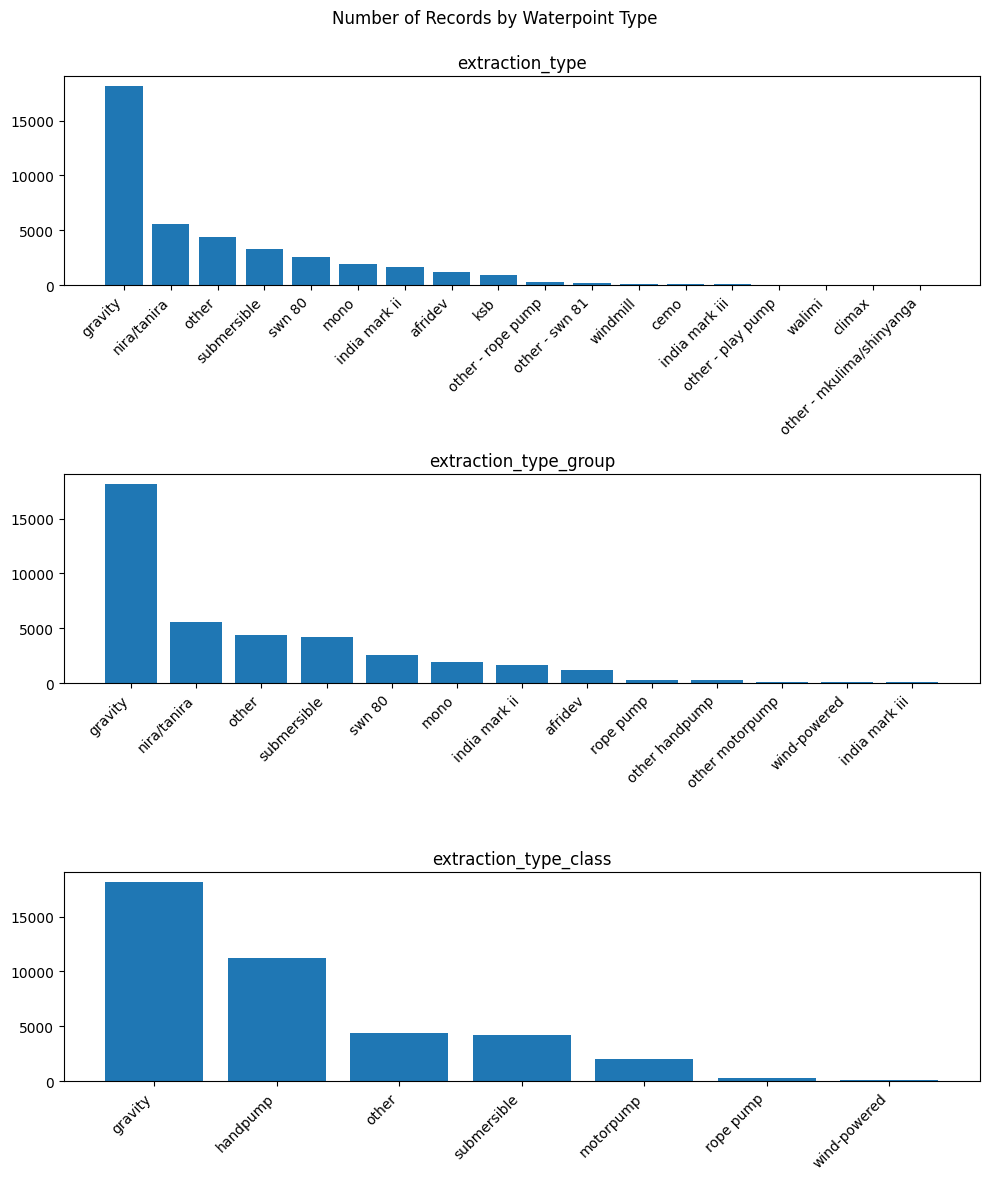

In [14]:
# prepare data
extraction_type = training_set.extraction_type.value_counts()
extraction_type_group = training_set.extraction_type_group.value_counts()
extraction_type_class = training_set.extraction_type_class.value_counts()

# plot data
fig, axes = plt.subplots(nrows=3, figsize=(10, 12))
axes[0].bar(extraction_type.index, extraction_type.values)
axes[0].set_title('extraction_type')
axes[1].bar(extraction_type_group.index, extraction_type_group.values)
axes[1].set_title('extraction_type_group')
axes[2].bar(extraction_type_class.index, extraction_type_class.values)
axes[2].set_title('extraction_type_class')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Waterpoint Type\n')
fig.tight_layout();


This is the first set of duplicate features where it is unclear which is the best to keep. We should only keep one, since they are duplicates.

'extraction_type' has the most heavily skewed distribution of values, and the number of records in the tail values may be too low to provide any value. Let's look at the categories with record counts below 5000 for each feature.

In [15]:
print("The values with <5000 record counts in extraction_type are: ")
print(extraction_type.loc[lambda x: x < 5000].to_string())
print()
print("The values with <5000 record counts in extraction_type_group are: ")
print(extraction_type_group.loc[lambda x: x < 5000].to_string())
print()
print("The values with <5000 record counts in extraction_type_class are: ")
print(extraction_type_class.loc[lambda x: x < 5000].to_string())

The values with <5000 record counts in extraction_type are: 
other                        4373
submersible                  3281
swn 80                       2529
mono                         1946
india mark ii                1638
afridev                      1204
ksb                           942
other - rope pump             312
other - swn 81                155
windmill                       70
cemo                           62
india mark iii                 60
other - play pump              56
walimi                         39
climax                         24
other - mkulima/shinyanga       2

The values with <5000 record counts in extraction_type_group are: 
other              4373
submersible        4223
swn 80             2529
mono               1946
india mark ii      1638
afridev            1204
rope pump           312
other handpump      252
other motorpump      86
wind-powered         70
india mark iii       60

The values with <5000 record counts in extraction_type_class a

As predicted, 'extraction_type' has too few values in the tail categories to be useful compared to the other two features.

'extraction_type_group' and 'extraction_type_class' are comparable in their possible contribution to the model. We need to determine which feature better separates the target classes.

Let's take a quick look at the dataframes to see how the classes are divided for each category.

In [16]:
# prepare class division tables
extraction_type_group_df = pd.DataFrame(training_set.extraction_type_group.groupby(
    training_set.status_group
).value_counts()).unstack()
extraction_type_class_df = pd.DataFrame(training_set.extraction_type_class.groupby(
    training_set.status_group
).value_counts()).unstack()

display(extraction_type_group_df)
display(extraction_type_class_df)

extraction_type_group                        \
extraction_type_group                 afridev gravity india mark ii   
status_group                                                          
functional                                828   10859           970   
functional needs repair                    27    1828            57   
non functional                            349    5458           611   

                                                                               \
extraction_type_group   india mark iii  mono nira/tanira other other handpump   
status_group                                                                    
functional                          29   752        3684   700            121   
functional needs repair              1    92         439   143             17   
non functional                      30  1102        1431  3530            114   

                                                                      \
extraction_type_group   other motorpump rope pump submersible swn 80   
status_group                                                           
functional                           40       208        2281   1429   
functional needs repair               7        11         175    143   
non functional                       39        93        1767    957   

                                      
extraction_type_group   wind-powered  
status_group                          
functional                        31  
functional needs repair            6  
non functional                    33

extraction_type_class                           \
extraction_type_class                 gravity handpump motorpump other   
status_group                                                             
functional                              10859     7061       792   700   
functional needs repair                  1828      684        99   143   
non functional                           5458     3492      1141  3530   

                                                            
extraction_type_class   rope pump submersible wind-powered  
status_group                                                
functional                    208        2281           31  
functional needs repair        11         175            6  
non functional                 93        1767           33

There are multiple instances in 'extraction_type_group' where there are too few records for each target class for the category to provide value in a multidimensional space. Let's keep 'extraction_type_class'.

##### Management

We have two features for how the pump is managed: 'management' and 'management_group'. Both features are categorical.

In [17]:
columns = [
    'management',
    'management_group',
]

print("The number of unique values in the management features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the management features are: 
management          12
management_group     5


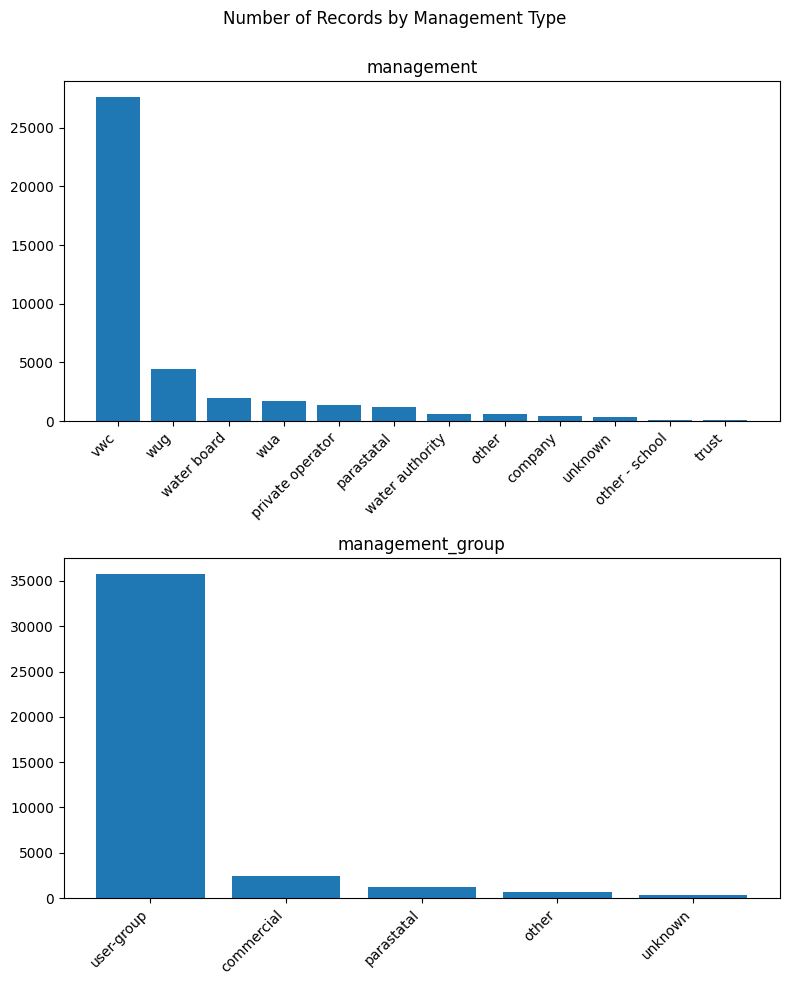

In [18]:
# prepare data
management = training_set.management.value_counts()
management_group = training_set.management_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
axes[0].bar(management.index, management.values)
axes[0].set_title('management')
axes[1].bar(management_group.index, management_group.values)
axes[1].set_title('management_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Management Type\n')
fig.tight_layout();

Neither feature seems particularly promising, as the vast majority of records in both features fall into a single category. Let's compare the tail values again, and choose the feature with the most records in the least-populated category.

In [19]:
print(f"management's least-populated category has a total of {management[-1]} records.")
print(f"management_group's least-populated category has a total of {management_group[-1]} records.")

management's least-populated category has a total of 52 records.
management_group's least-populated category has a total of 378 records.


We will keep 'management_group'.

##### Payment

We have two features for the water's cost: 'payment' and 'payment_type'. Both features are categorical.

In [20]:
columns = [
    'payment',
    'payment_type',
]

print("The number of unique values in the payment features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the payment features are: 
payment         7
payment_type    7


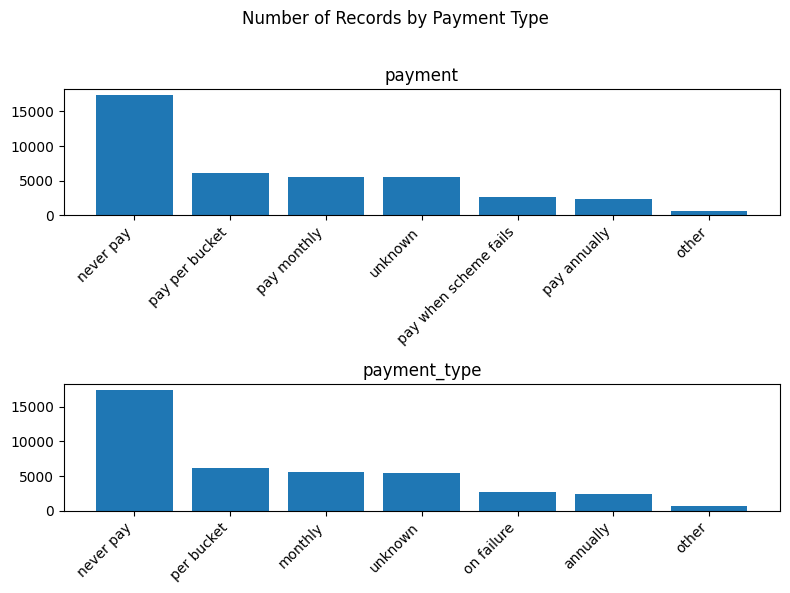

In [21]:
# prepare data
payment = training_set.payment.value_counts()
payment_type = training_set.payment_type.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(payment.index, payment.values)
axes[0].set_title('payment')
axes[1].bar(payment_type.index, payment_type.values)
axes[1].set_title('payment_type')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Payment Type\n')
fig.tight_layout();

The features are exactly the same. Let's keep 'payment_type', since it's name is a more accurate description of the feature.

##### Water Quality

We have two features for the water's quality: 'water_quality' and 'quality_group'. Both features are categorical.

In [22]:
columns = [
    'water_quality',
    'quality_group',
]

print("The number of unique values in the Water Quality features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Quality features are: 
water_quality    8
quality_group    6


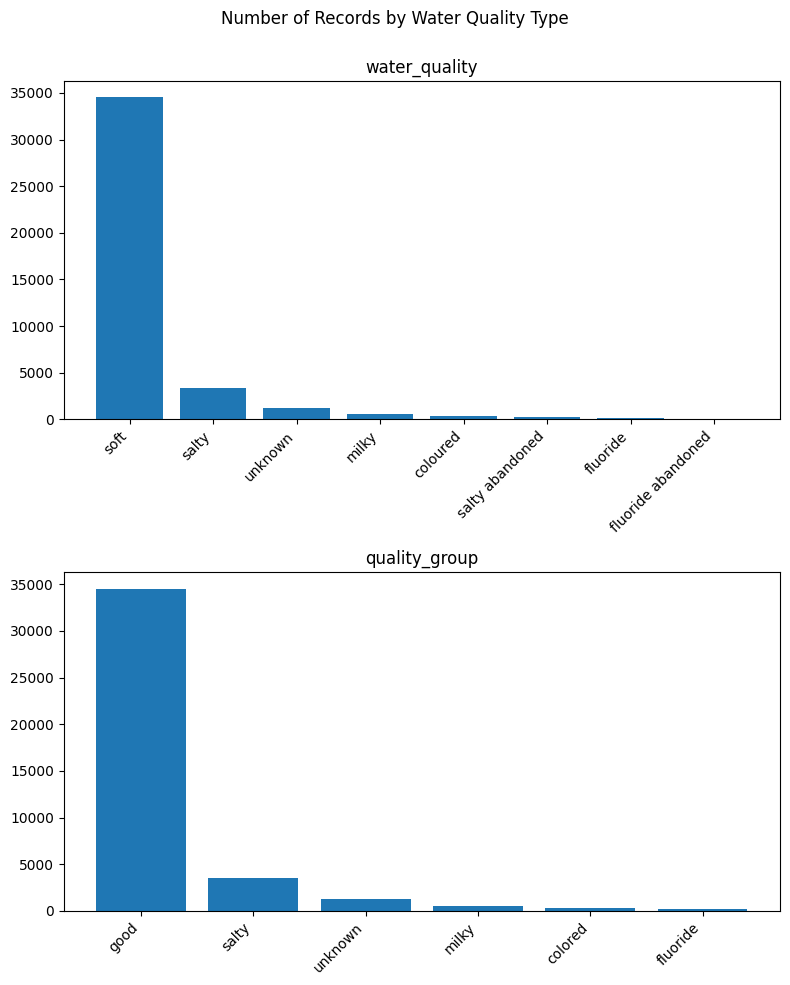

In [23]:
# prepare data
water_quality = training_set.water_quality.value_counts()
quality_group = training_set.quality_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 10))
axes[0].bar(water_quality.index, water_quality.values)
axes[0].set_title('water_quality')
axes[1].bar(quality_group.index, quality_group.values)
axes[1].set_title('quality_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Quality Type\n')
fig.tight_layout();

Again, neither feature seems particularly valuable to our model. The differences in the two features come from the 'abandoned' tag. Let's look at the class separations by category and see if this tag is valuable.

In [24]:
# prepare class division tables
water_quality_df = pd.DataFrame(training_set.water_quality.groupby(
    training_set.status_group
).value_counts()).unstack()
quality_group_df = pd.DataFrame(training_set.quality_group.groupby(
    training_set.status_group
).value_counts()).unstack()

display(water_quality_df)
display(quality_group_df)

water_quality                                     \
water_quality                coloured fluoride fluoride abandoned  milky   
status_group                                                               
functional                      177.0    108.0                4.0  302.0   
functional needs repair          31.0     10.0                NaN   10.0   
non functional                  132.0     18.0                6.0  242.0   

                                                                  
water_quality             salty salty abandoned     soft unknown  
status_group                                                      
functional               1529.0           115.0  19533.0   164.0  
functional needs repair   156.0            46.0   2665.0    28.0  
non functional           1634.0            65.0  12334.0  1083.0

quality_group                                    
quality_group                 colored fluoride   good milky salty unknown
status_group                                                             
functional                        177      112  19533   302  1644     164
functional needs repair            31       10   2665    10   202      28
non functional                    132       24  12334   242  1699    1083

'flouride abandoned' has only non-functional pumps, and the differences in class proportions between 'salty abandoned' and 'salty' are considerable. Let's keep 'water_quality', since the existence of the 'abandoned' tag appears valuable.

##### Water Quantity

We have three features for water quantity: 'amount_tsh', 'quantity', and 'quantity_group'.

'amount_tsh' is a numerical value, where TSH is an acronym for "Total Static Head". It is described on Kaggle as the amount of water available to the waterpoint. We will keep this feature for now and research it later.

The remaining features, 'quantity' and 'quantity_group', are both categorical.

In [25]:
columns = [
    'quantity',
    'quantity_group',
]

print("The number of unique values in the Water Quantity features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Quantity features are: 
quantity          5
quantity_group    5


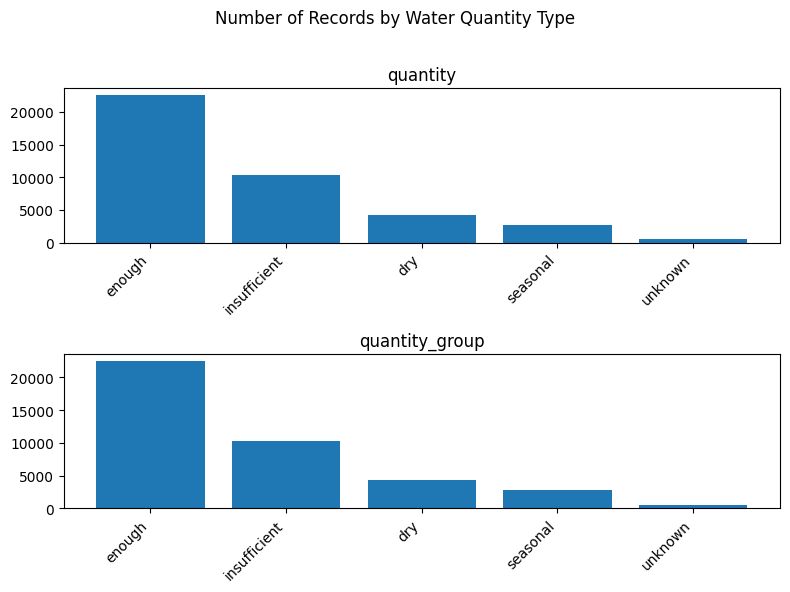

In [26]:
# prepare data
quantity = training_set.quantity.value_counts()
quantity_group = training_set.quantity_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(quantity.index, quantity.values)
axes[0].set_title('quantity')
axes[1].bar(quantity_group.index, quantity_group.values)
axes[1].set_title('quantity_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Quantity Type\n')
fig.tight_layout();

These features are the exact same. We will choose 'quantity_group', as it is a more descriptive name than 'quantity', which sounds like a numerical feature.

##### Water Source

We have three features for the water's source: 'source', 'source_type', and 'source_class'. All three features are categorical.

In [27]:
columns = [
    'source',
    'source_type',
    'source_class'
]

print("The number of unique values in the Water Source features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Source features are: 
source          10
source_type      7
source_class     3


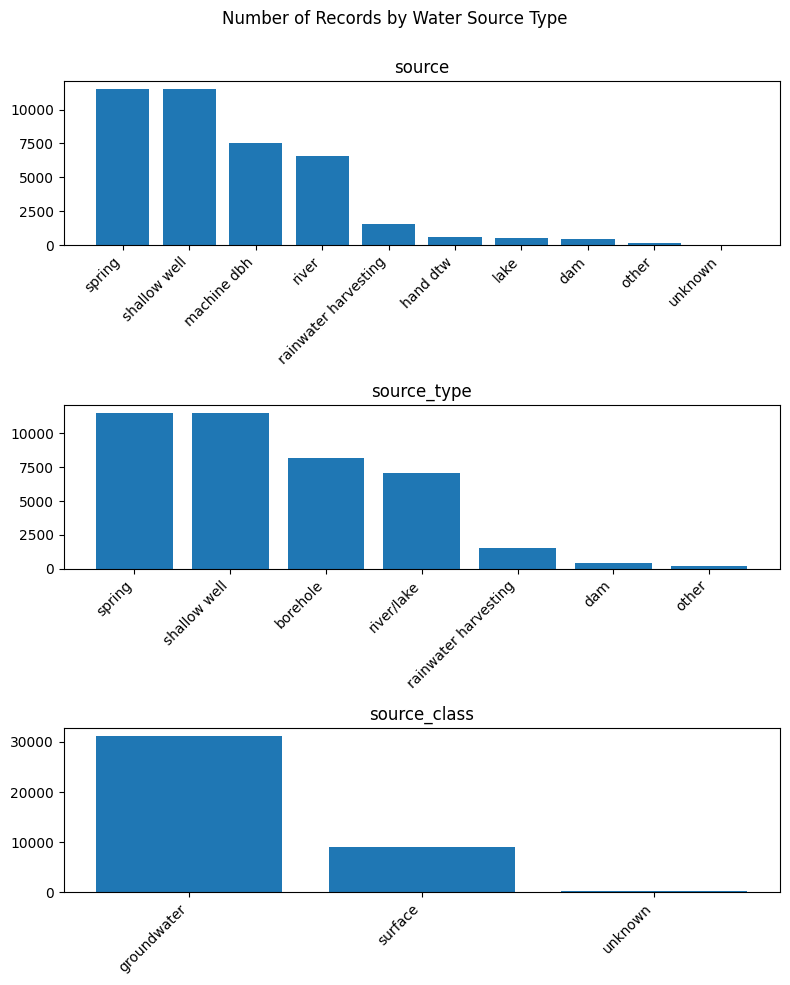

In [28]:
# prepare data
source = training_set.source.value_counts()
source_type = training_set.source_type.value_counts()
source_class = training_set.source_class.value_counts()

# plot data
fig, axes = plt.subplots(nrows=3, figsize=(8, 10))
axes[0].bar(source.index, source.values)
axes[0].set_title('source')
axes[1].bar(source_type.index, source_type.values)
axes[1].set_title('source_type')
axes[2].bar(source_class.index, source_class.values)
axes[2].set_title('source_class')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Water Source Type\n')
fig.tight_layout();

Both 'source' and 'source_type' look like promising features (the number of unique values in 'source_class' is insufficient considering the distribution of records in the other two features), but the 'unknown' category in 'source' may not have enough records.

In [29]:
print(f"The number of records in the 'unknown' class of 'source' is {source[-1]}.")

The number of records in the 'unknown' class of 'source' is 45.


This record count is not low enough for us to disregard the value from the additional categories in source. Let's take a look at the class distributions for eacy category.

In [30]:
# prepare class division tables
source_df = pd.DataFrame(training_set.source.groupby(
    training_set.status_group
).value_counts()).unstack()
source_type = pd.DataFrame(training_set.source_type.groupby(
    training_set.status_group
).value_counts()).unstack()

display(source_df)
display(source_type)

source                                  \
source                     dam hand dtw lake machine dbh other   
status_group                                                     
functional                 156      342  111        3726    87   
functional needs repair     20       11    7         340     1   
non functional             253      256  410        3462    59   

                                                                                
source                  rainwater harvesting river shallow well spring unknown  
status_group                                                                    
functional                               934  3695         5668   7194      19  
functional needs repair                  211   835          660    858       3  
non functional                           400  2019         5164   3468      23

source_type                                  \
source_type                borehole  dam other rainwater harvesting   
status_group                                                          
functional                     4068  156   106                  934   
functional needs repair         351   20     4                  211   
non functional                 3718  253    82                  400   

                                                        
source_type             river/lake shallow well spring  
status_group                                            
functional                    3806         5668   7194  
functional needs repair        842          660    858  
non functional                2429         5164   3468

There are too many instances of single-digit record counts in source. Let's keep 'source_type'.

##### Waterpoint Type

We have two features for waterpoint type: 'waterpoint_type' and 'waterpoint_type_group'. Both features are categorical.

In [31]:
columns = [
    'waterpoint_type',
    'waterpoint_type_group'
]

print("The number of unique values in the Water Source features are: ")
print(pd.Series(
    data = [training_set[column].nunique() for column in columns],
    index= columns
).to_string())

The number of unique values in the Water Source features are: 
waterpoint_type          7
waterpoint_type_group    6


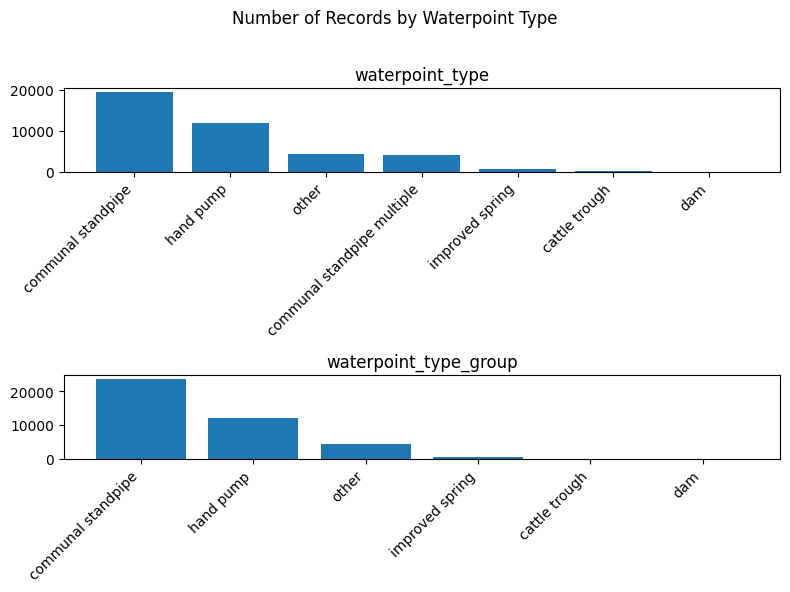

In [32]:
# prepare data
waterpoint_type = training_set.waterpoint_type.value_counts()
waterpoint_type_group = training_set.waterpoint_type_group.value_counts()

# plot data
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
axes[0].bar(waterpoint_type.index, waterpoint_type.values)
axes[0].set_title('waterpoint_type')
axes[1].bar(waterpoint_type_group.index, waterpoint_type_group.values)
axes[1].set_title('waterpoint_type_group')
for ax in axes:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle('Number of Records by Waterpoint Type\n')
fig.tight_layout();

'waterpoint_type_group' has a division of the 'communal standpipe' category with a 'multiple' tag. Having a separation in the most populous category is valuable. We will keep 'waterpoint_type'.

We have addressed all duplicate features.

#### HCCCs (High Cardinality Categorical Columns)

We have marked quite a few features to drop during cleaning. Our next goal is to identify and eliminate any high-cardinality categorical features which may introduce noise into our dataset.

Let's take a tally of the remaining features to keep track of what features we need to explore.

- amount_tsh
- date_recorded
- funder
- gps_height
- installer
- longitude
- latitude
- wpt_name
- basin
- population
- public_meeting
- recorded_by
- scheme_management
- permit
- construction_year
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

We do not need to consider numerical features (unless they are coded categorical columns), date features, or boolean features. These are:

- amount_tsh
- date_recorded
- gps_height
- longitude
- latitude
- population
- public_meeting
- construction_year

We also do not need to consider features which have been examined when eliminating duplicates. These are:

- basin
- scheme_management
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

This leaves us with the following features:

- funder
- installer
- wpt_name
- recorded_by

In [33]:
print(f"'funder' has {training_set.funder.nunique()} unique values.")
print(f"'installer' has {training_set.installer.nunique()} unique values.")
print(f"'wpt_name' has {training_set.wpt_name.nunique()} unique values.")
print(f"'recorded_by' has {training_set.recorded_by.nunique()} unique values.")

'funder' has 1572 unique values.
'installer' has 1770 unique values.
'wpt_name' has 26601 unique values.
'recorded_by' has 1 unique values.


'wpt_name' is a clear HCCC, so it can be dropped.

'recorded_by' only has one unique value, and therefore provides no target class separation, so it can be dropped as well.

'funder' and 'installer' are HCCCs, but we should view how the highest-proportion categories are distributed before disregarding them.

In [34]:
print("The five categories in 'funder' with the largest proportion of records are: ")
print(training_set.funder.value_counts(normalize=True)[:5].to_string())
print()
print("The five categories in 'installer' with the largest proportion of records are: ")
print(training_set.installer.value_counts(normalize=True)[:5].to_string())

The five categories in 'funder' with the largest proportion of records are: 
Government Of Tanzania    0.162087
Danida                    0.056462
Hesawa                    0.039968
Rwssp                     0.025109
World Bank                0.024134

The five categories in 'installer' with the largest proportion of records are: 
DWE           0.312917
Government    0.031600
RWE           0.021717
Commu         0.019239
DANIDA        0.018765


The categories are less mismatched than expected. There is an opportunity to consolidate the low-record-count categories in each feature under a common 'other' category. Let's explore how many categories there are in each feature with record counts less than 1000, 100, and 10.

In [35]:
funder_under_1000 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 1000
].count()
funder_under_100 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 100
].count()
funder_under_10 = training_set.funder.value_counts().loc[
    training_set.funder.value_counts() < 10
].count()
installer_under_1000 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 1000
].count()
installer_under_100 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 100
].count()
installer_under_10 = training_set.installer.value_counts().loc[
    training_set.installer.value_counts() < 10
].count()

print(f"'funder' has {funder_under_1000} unique categories with record counts less than 1000.")
print(f"'funder' has {funder_under_100} unique categories with record counts less than 100.")
print(f"'funder' has {funder_under_10} unique categories with record counts less than 10.")
print()
print(f"'installer' has {installer_under_1000} unique categories with record counts less than 1000.")
print(f"'installer' has {installer_under_100} unique categories with record counts less than 100.")
print(f"'installer' has {installer_under_10} unique categories with record counts less than 10.")

'funder' has 1569 unique categories with record counts less than 1000.
'funder' has 1511 unique categories with record counts less than 100.
'funder' has 1235 unique categories with record counts less than 10.

'installer' has 1768 unique categories with record counts less than 1000.
'installer' has 1714 unique categories with record counts less than 100.
'installer' has 1440 unique categories with record counts less than 10.


This is an interesting result. We can likely consolidate the low-record categories in these features into a single category. We will move forward without them to develop the MVP and save this idea for a second iteration of the model building process.

For now, we will drop these features.

#### Explicit Nulls

After the elimination of HCCCs, the remaining features are:
- amount_tsh
- date_recorded
- gps_height
- longitude
- latitude
- basin
- population
- public_meeting
- scheme_management
- permit
- construction_year
- extraction_type_class
- management_group
- payment_type
- water_quality
- quantity_group
- source_type
- waterpoint_type

Let's take a look at the explicit nulls in our remaining features.

In [36]:
surviving_features = [
    'amount_tsh',
    'date_recorded',
    'gps_height',
    'longitude',
    'latitude',
    'basin',
    'population',
    'public_meeting',
    'scheme_management',
    'permit',
    'construction_year',
    'extraction_type_class',
    'management_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'waterpoint_type'
]

print("For each remaining feature, the count of explicit nulls is: ")
print(training_set[surviving_features].isnull().sum().to_string())

For each remaining feature, the count of explicit nulls is: 
amount_tsh                  0
date_recorded               0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
population                  0
public_meeting           2266
scheme_management        2597
permit                   2056
construction_year           0
extraction_type_class       0
management_group            0
payment_type                0
water_quality               0
quantity_group              0
source_type                 0
waterpoint_type             0


Only three of our features have explicit nulls, and for each of those features, the proportion of null values is about 5%. It will be acceptable to impute these values as necessary.

#### Feature Research & Implicit Nulls

Now that we're working with a manageable number of features, let's explore each of them more to better understand them and determine possible implicit null values.

##### amount_tsh

As stated before, amount_tsh in the description given by Kaggle is "amount of water available to the waterpoint".

Some research into total static head yields a more complicated description. Per [this post](https://inspectapedia.com/water/Well_Static_Head_Definition.php), "the static head in a well is is not the total amount of water than can be pumped out of the well, it's just where we start." There is also [this pdf](https://www.pumpfundamentals.com/download/book/chapter3.pdf) which describes total static head as "the difference between the discharge static head and the suction static head, or the difference in elevation at the outlet including the pressure head at the outlet, and the elevation at the inlet including the pressure head at the inlet."

The data does not include units, which would be helpful in understanding whether the Kaggle description is sufficient or not. We must assume that the Kaggle description is correct, and that amount_tsh is a measure of how much water is available to the pump, though we still do not know the unit of measurement.

Let's take a quick look at the distribution to see what we can uncover about the data.

<AxesSubplot: >

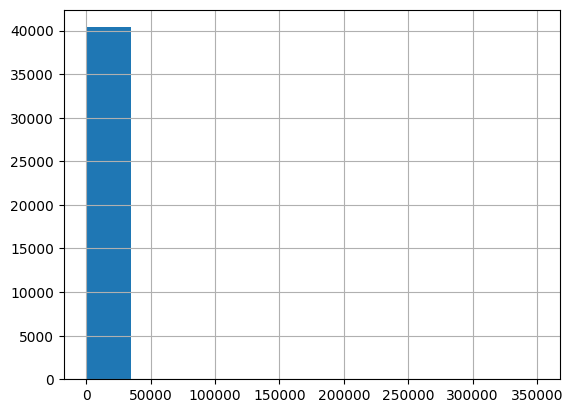

In [37]:
display(training_set.amount_tsh.hist())

We have some clear outliers. Let's see how many there are.

In [38]:
gt_50k = training_set.amount_tsh.loc[training_set.amount_tsh > 50000].count()

print(f"There are {gt_50k} records where 'amount_tsh' is greater than 50,000.")

There are 13 records where 'amount_tsh' is greater than 50,000.


Since there are only 14 outlier values in 'amount_tsh', we will impute null values for these values. We may return to these values and explore them further in a second iteration of this project.

Let's look at a distribution of the remaining values.

<AxesSubplot: >

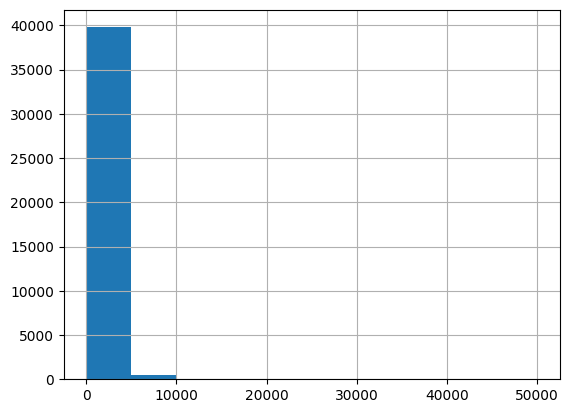

In [39]:
display(training_set.amount_tsh.loc[training_set.amount_tsh <= 50000].hist())

This raises suspicion. How many of these values are zero?

In [44]:
amount_tsh_zero = training_set.amount_tsh.loc[training_set.amount_tsh == 0.0].count()

print(f"There are {amount_tsh_zero} records where 'amount_tsh' is zero.")
print(f"This is {round((amount_tsh_zero/training_set.shape[0])*100, 2)}% of the feature's total values.")

There are 28294 records where 'amount_tsh' is zero.
This is 70.05% of the feature's total values.


More than two-thirds of the values in the dataset for 'amount_tsh' are zero.

This is problematic, since not only is zero a possible value of 'amount_tsh' (where there is no water available to the waterpoint) but it is also a possibility for an implicit null (if the user does not know the value, they may enter zero in its place).

We must consider the trade-off in using this feature, as it can be a valuable indicator of functionality, but we don't want it to add noise to our model. Let's take a look at one more visualization of 'amount_tsh'. Since the values are heavily skewed across such a large range, let's separate the values by our target variable and view them on a log scale.

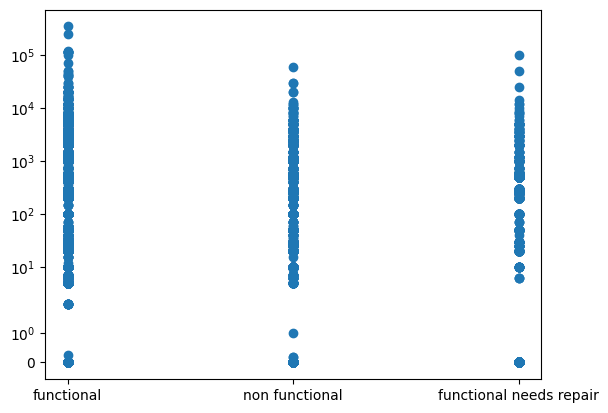

In [51]:
fig, ax = plt.subplots()

ax.scatter(training_set.status_group, training_set.amount_tsh)
ax.set_yscale('symlog')

A much more acceptable distribution of values. In conjunction with other features, our model may find 'amount_tsh' useful when this transformation is applied.

If we intend to use a log10 transformation, we will need to address the zeros in the feature. The easiest solution is to add 1 to all values, since $log_{10}1=0$. 

In the data preparation phase, we will use a numpy.log10(x+1) transformation on the 'amount_tsh' feature.

##### date_recorded and construction_year

'date_recorded' is the date the record was entered. 'construction_year' is the year the pump was built.


On its own, 'date_recorded' is not a particularly useful feature, but when combined with 'construction_year', this data becomes far more valuable. We can use these features together to determine the pump's age.

A pitfall we may encounter is to disregard 'date_recorded' in favor of simply using 'construction_year' to determine the pump's age. But pump age is an interval of time, and going from the year of construction to the current date would be inconsistent with the data. The 'status_group' of the pump is what was determined on the date it was entered. A pump recorded as functional in 2015 may no longer be functional today. A consistent interval measure of pump age would be the recorded date minus the construction date.

We have another issue in that the time formats of 'date_recorded' and 'construction_year' are incongruent. 'date_recorded' is measured to the day, while 'construction_year' is only the year of construction. We are restricted by 'construction_year'; our pump age can only be as accurate as the year. Additionally, we do not know the exact date of construction during the year, so we may overestimate or underestimate the pump age by a maximum of one year. For example, a pump constructed in November 2000 and recorded in January 2010 would only be 9 years and 3 months old, but we would calcuate the pump as being 10 years old.

There is nothing we can do about this, but it will be important to keep in mind how this may affect our model when we create our 'pump_age' feature.

Let's return to 'date_recorded'. Since this is an object datatype, we can assume that this is in string format, but this is time series data. Let's convert it to a datetime and view the distribution of values.

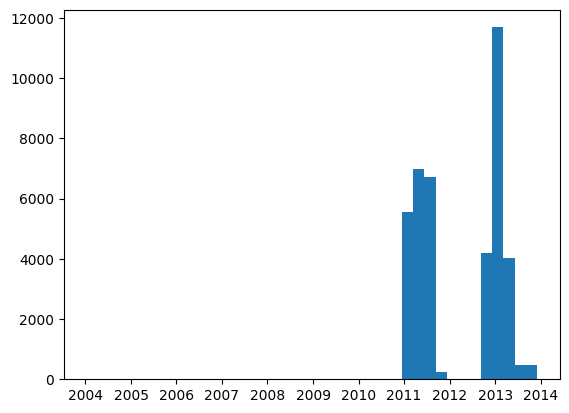

In [57]:
# convert to datetime
date_recorded_dt = pd.to_datetime(training_set.date_recorded, format="%Y-%m-%d")

plt.hist(date_recorded_dt, bins=40);

We didn't get any errors when converting the string values to datetimes, so there probably aren't any hard-coded implicit nulls in the data.

Most of the 'date_recorded' values are between 2011 and 2014. Let's see how many records there are before that.

In [60]:
date_recorded_pre2011 = date_recorded_dt.loc[date_recorded_dt < pd.to_datetime("2011-01-01")]

print(f"There are {date_recorded_pre2011.count()} records in 'date_recorded' with dates before 2011.")
print("Those dates are: ")
print(date_recorded_pre2011.to_string())

There are 22 records in 'date_recorded' with dates before 2011.
Those dates are: 
id
14354   2004-12-01
2934    2004-04-01
59286   2004-12-01
33770   2004-12-01
35238   2004-12-01
15921   2004-03-06
5971    2004-03-01
20122   2004-12-01
53086   2004-01-07
20198   2004-05-01
3995    2004-08-01
54360   2004-05-01
6176    2004-12-01
28696   2004-09-01
9195    2004-03-01
44753   2004-09-01
20534   2004-03-01
47991   2004-07-01
51853   2004-12-01
35841   2004-12-01
39905   2004-12-01
1251    2004-12-01


These are indeed anomalous values compared to the rest of the dataset, but they don't appear to be null values. We can consider them legitimate, especially since we will not be using 'date_recorded' directly in our model.

Let's take a look at 'construction_year'.

<AxesSubplot: >

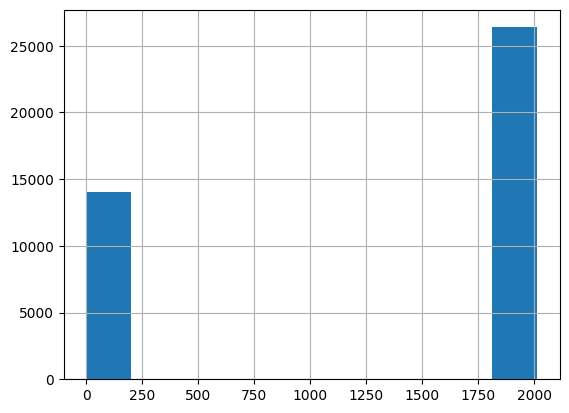

In [61]:
training_set.construction_year.hist()

It appears we have some zero-coded values, since it is highly unlikely that these pumps were built shortly after 0 CE. Let's see how many we have.

In [62]:
construction_year_zero = training_set.construction_year.loc[training_set.construction_year == 0]

print(f"There are {construction_year_zero.count()} zero-coded values in 'constructon_year'.")

There are 14011 zero-coded values in 'constructon_year'.


That's a lot of implicit null values! We'll need to deal with these when we create our pump age feature.

Let's look at the distribution of legitimate values.

<AxesSubplot: >

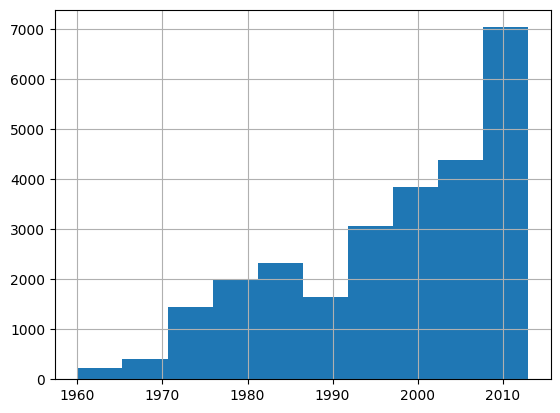

In [63]:
training_set.construction_year.loc[training_set.construction_year > 0].hist()

This is a much more reasonable distribution of values. Again, we'll need to account for the implicit nulls when we're creating our pump age feature, but we have a better idea of the date date we're working with.

##### Location Data

We have four features related to location:
- gps_height
- latitude
- longitude
- basin

Altitude, latitude, and longitude are all valuable features, since different geographical locations are subject to different weather patterns, which can directly affect the well's functionality.

Basin, as stated before when dealing with the duplicate features, is a categorical locational feature identifying the larger basin the well (probably) draws its water from.

We will explore all of these values for implicit nulls and determine their possible contribution to the model.

Let's start with 'gps_height'.

<AxesSubplot: >

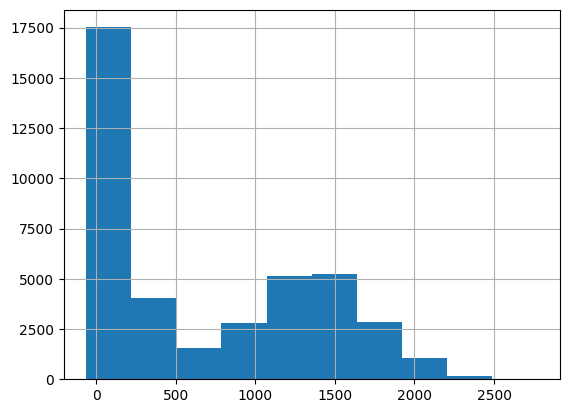

In [64]:
training_set.gps_height.hist()

In [65]:
gps_height_zero = training_set.gps_height.loc[training_set.gps_height == 0]

print(f"There are {gps_height_zero.count()} zero-coded values for 'gps_height'.")

There are 13819 zero-coded values for 'gps_height'.


This is, like 'amount_tsh', an ambiguous value of zero, since it could be an implicit null or a legitimate value (the well is at sea level). A better way to determine which of these values is legitimate would be to compare their locations with a real altitude map of Tanzania. This we would save for a second iteration of this project. For now, we will assume that the zero-coded values are legitimate.

We will compare 'latitude' and 'longitude' in a single plot, as they combine to provide exact geographical location.

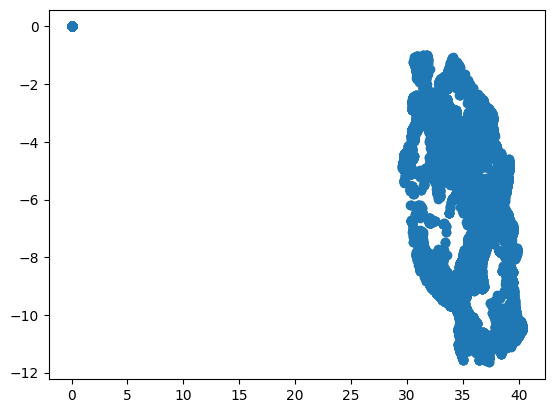

In [68]:
plt.scatter(training_set.longitude, training_set.latitude);

We have (0, 0) coordinates - the infamous "null island". We need to account for these in the data preparation phase. Let's view the scatterplot without these nulls.

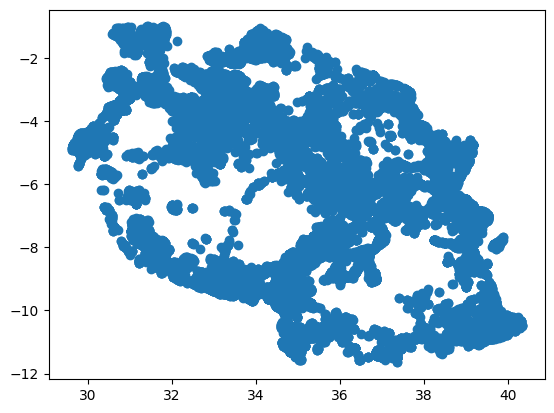

In [71]:
long_lat_not_null = training_set.loc[(training_set.longitude > 1.0) & (training_set.latitude < -0.2)]

plt.scatter(long_lat_not_null.longitude, long_lat_not_null.latitude);

That looks much more like a map of Tanzania.

Let's review the surface level data of 'basin'.

In [73]:
print(f"There are {training_set.basin.nunique()} unique categories in 'basin'.")
print("The proportions of data for each category are: ")
print(training_set.basin.value_counts(normalize=True).to_string())

There are 9 unique categories in 'basin'.
The proportions of data for each category are: 
Lake Victoria              0.171990
Pangani                    0.150871
Rufiji                     0.134036
Internal                   0.130942
Lake Tanganyika            0.108437
Wami / Ruvu                0.100936
Lake Nyasa                 0.084918
Ruvuma / Southern Coast    0.076104
Lake Rukwa                 0.041766


This is a relatively even distribution of value counts, and there are no glaring implicit nulls in the dataset. This seems like an excellent feature to leave as is.

##### Population